## Titanic Prediction


### Cleaning

In [52]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Load the datasets
gender_submission = pd.read_csv('gender_submission.csv')
test = pd.read_csv('test.csv')
train = pd.read_csv('train.csv')

# Drop columns that are unnecessary or irrelevant for the analysis
columns_to_drop = ['Cabin', 'Ticket', 'Name']
train = train.drop(columns=columns_to_drop, errors='ignore')
test = test.drop(columns=columns_to_drop, errors='ignore')

# Handle missing values
train['Age'].fillna(train['Age'].median(), inplace=True)
test['Age'].fillna(test['Age'].median(), inplace=True)
train['Embarked'].fillna(train['Embarked'].mode()[0], inplace=True)
test['Embarked'].fillna(test['Embarked'].mode()[0], inplace=True)
test['Fare'].fillna(test['Fare'].median(), inplace=True)

# Convert categorical variables to numerical
train = pd.get_dummies(train, columns=['Sex', 'Embarked'], drop_first=True)
test = pd.get_dummies(test, columns=['Sex', 'Embarked'], drop_first=True)

# Ensure both train and test datasets have the same columns
missing_cols = set(train.columns) - set(test.columns)
for col in missing_cols:
    if col != 'Survived':
        test[col] = 0

test = test[train.columns.drop('Survived')]

# Save cleaned datasets
train.to_csv('cleaned_train.csv', index=False)
test.to_csv('cleaned_test.csv', index=False)

print("\nData cleaning complete.")

print(f"There are {len(gender_submission.index)} instances.")
print(f"There are {len(train.index)} instances.")
print(f"There are {len(test.index)} instances.")


Data cleaning complete.
There are 418 instances.
There are 891 instances.
There are 418 instances.


C:\Users\yosak\AppData\Local\Temp\ipykernel_16612\3428617428.py:23: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train['Age'].fillna(train['Age'].median(), inplace=True)
C:\Users\yosak\AppData\Local\Temp\ipykernel_16612\3428617428.py:24: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy

### Train/Test

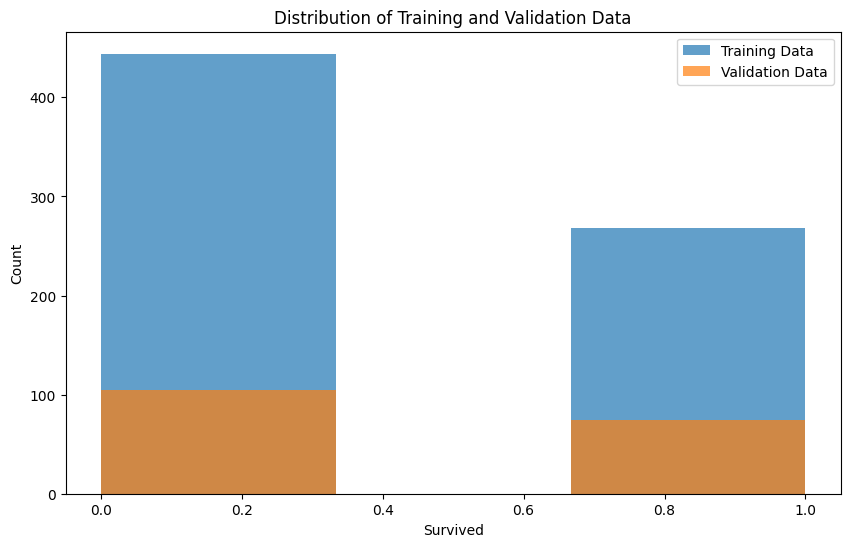

In [48]:
# Split the training data into features and target
X = train.drop('Survived', axis=1).values.astype(np.float64)
y = train['Survived'].values.astype(np.float64)

# Split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Plot the training and validation data distribution
plt.figure(figsize=(10, 6))
plt.hist(y_train, bins=3, alpha=0.7, label='Training Data')
plt.hist(y_val, bins=3, alpha=0.7, label='Validation Data')
plt.xlabel('Survived')
plt.ylabel('Count')
plt.title('Distribution of Training and Validation Data')
plt.legend()
plt.show()


### Modelling

In [49]:
# Linear Regression using Statsmodels
X_train_sm = sm.add_constant(X_train)
X_val_sm = sm.add_constant(X_val)
linear_model = sm.OLS(y_train, X_train_sm).fit()
print(linear_model.summary())

# Predict using linear regression model
y_pred_val_lr = linear_model.predict(X_val_sm)
y_pred_class_lr = np.array([1 if i > 0.5 else 0 for i in y_pred_val_lr])

# Train a logistic regression model using gradient descent
# Initialize parameters
n_features = X_train.shape[1]
weights = np.zeros(n_features, dtype=np.float64)
bias = 0.0
learning_rate = 0.01
n_iterations = 10000

# Sigmoid function
def sigmoid(z):
    return 1 / (1 + np.exp(-np.array(z, dtype=np.float64)))

# Training the model using gradient descent
for i in range(n_iterations):
    # Linear model
    linear_model_gd = np.dot(X_train, weights) + bias
    # Prediction
    y_predicted = sigmoid(linear_model_gd)
    
    # Compute gradients
    dw = (1 / len(y_train)) * np.dot(X_train.T, (y_predicted - y_train))
    db = (1 / len(y_train)) * np.sum(y_predicted - y_train)
    
    # Debugging prints
    if i % 1000 == 0:
        print(f"Iteration {i}: weights shape: {weights.shape}, dw shape: {dw.shape}, bias: {bias}, db: {db}")

    # Update parameters
    weights -= learning_rate * dw
    bias -= learning_rate * db

# Train a simple neural network model using TensorFlow
model = Sequential()
model.add(Dense(200, input_dim=n_features, activation='sigmoid'))
model.add(Dense(200, activation='sigmoid'))
model.add(Dense(200, activation='sigmoid'))
model.add(Dense(1, activation='linear'))

model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.fit(X_train.astype(np.float32), y_train.astype(np.float32), epochs=1750, batch_size=64, validation_data=(X_val.astype(np.float32), y_val.astype(np.float32)))

C:\Users\yosak\AppData\Local\Temp\ipykernel_16612\1940346664.py:21: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-np.array(z, dtype=np.float64)))


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.385
Model:                            OLS   Adj. R-squared:                  0.377
Method:                 Least Squares   F-statistic:                     48.76
Date:                Tue, 29 Oct 2024   Prob (F-statistic):           2.41e-68
Time:                        16:24:35   Log-Likelihood:                -321.44
No. Observations:                 712   AIC:                             662.9
Df Residuals:                     702   BIC:                             708.6
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.2595      0.087     14.409      0.0

c:\Users\yosak\anaconda3\envs\se411_Final_Project\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.3071 - mae: 0.4601 - val_loss: 0.2353 - val_mae: 0.4824
Epoch 2/1750
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2384 - mae: 0.4588 - val_loss: 0.2263 - val_mae: 0.4647
Epoch 3/1750
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2255 - mae: 0.4591 - val_loss: 0.2223 - val_mae: 0.4423
Epoch 4/1750
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2120 - mae: 0.4380 - val_loss: 0.2160 - val_mae: 0.4577
Epoch 5/1750
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2268 - mae: 0.4473 - val_loss: 0.2014 - val_mae: 0.4307
Epoch 6/1750
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2113 - mae: 0.4197 - val_loss: 0.2139 - val_mae: 0.4108
Epoch 7/1750
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2144 - mae: 0.4062 - val_loss: 0.2157 - val_mae: 0.4086
Epoch 8/1750
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2206 - mae: 0.4290 - val_loss: 0.2015 - val_mae: 0.4321
Epoch 9/1750
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2202 -

### Prediction

In [50]:
# Make predictions on the validation set using gradient descent model
linear_model_val = np.dot(X_val, weights) + bias
y_pred_val_gd = sigmoid(linear_model_val)
y_pred_class_gd = np.array([1 if i > 0.5 else 0 for i in y_pred_val_gd])

# Make predictions on the validation set using neural network model
y_pred_nn_val = model.predict(X_val.astype(np.float32)).flatten()
y_pred_nn_class = np.array([1 if i > 0.5 else 0 for i in y_pred_nn_val])

# Make predictions on the test set using gradient descent model
linear_model_test = np.dot(test.values, weights) + bias
y_pred_test_gd = sigmoid(linear_model_test)
test_predictions_gd = np.array([1 if i > 0.5 else 0 for i in y_pred_test_gd])

# Make predictions on the test set using neural network model
y_pred_nn_test = model.predict(test.values.astype(np.float32)).flatten()
test_predictions_nn = np.array([1 if i > 0.5 else 0 for i in y_pred_nn_test])

# Save predictions
gender_submission['Survived'] = test_predictions_nn
gender_submission.to_csv('submission.csv', index=False)

print("\nTraining, testing, and prediction complete.")

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 767us/step

Training, testing, and prediction complete.


### Evaluvation


Linear Regression R-squared on validation set: 0.4381147692850976


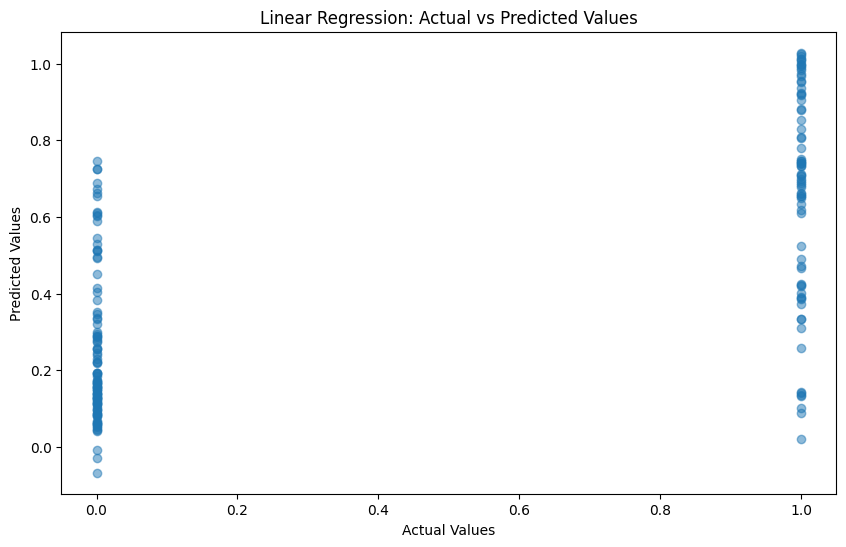


Logistic Regression Accuracy on validation set: 0.4301675977653631

Classification Report:
              precision    recall  f1-score   support

         0.0       0.60      0.09      0.15       105
         1.0       0.41      0.92      0.57        74

    accuracy                           0.43       179
   macro avg       0.51      0.50      0.36       179
weighted avg       0.52      0.43      0.32       179


Confusion Matrix:
[[ 9 96]
 [ 6 68]]


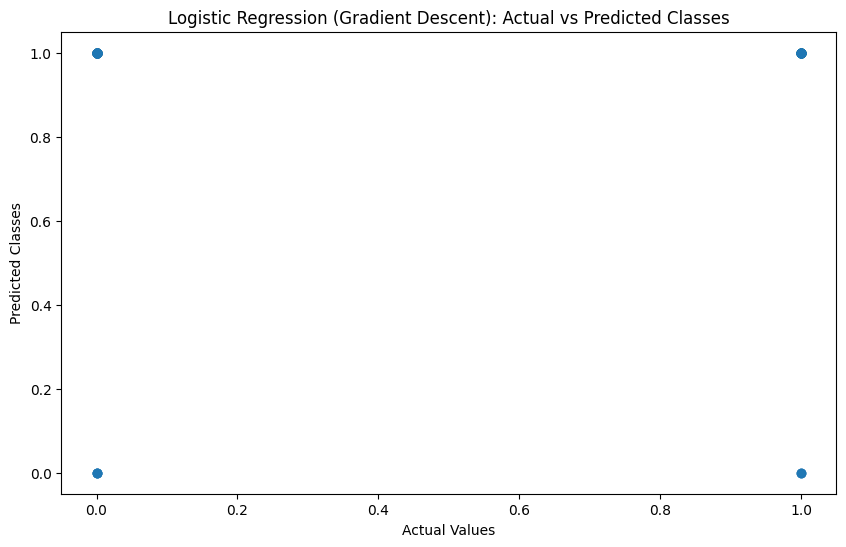


Neural Network Accuracy on validation set: 0.7653631284916201

Classification Report:
              precision    recall  f1-score   support

         0.0       0.79      0.82      0.80       105
         1.0       0.73      0.69      0.71        74

    accuracy                           0.77       179
   macro avg       0.76      0.75      0.76       179
weighted avg       0.76      0.77      0.76       179


Confusion Matrix:
[[86 19]
 [23 51]]


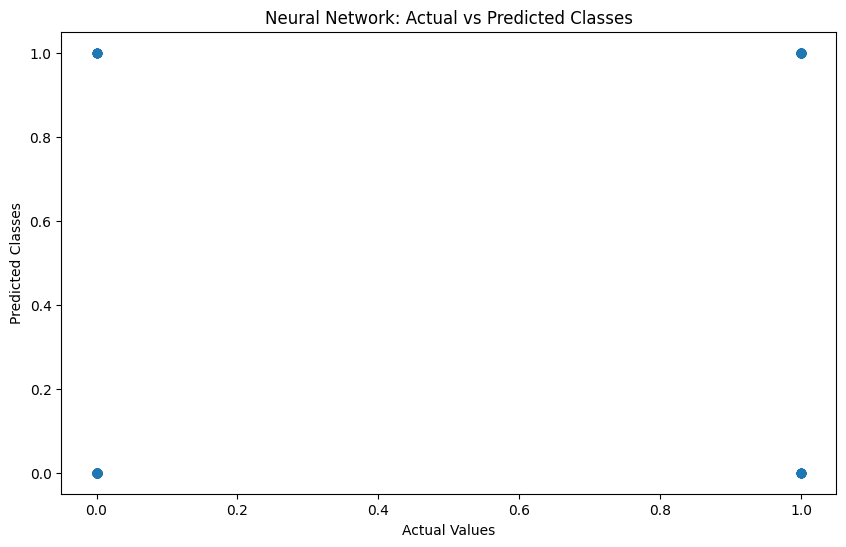

AttributeError: 'dict' object has no attribute 'history'

In [53]:
from sklearn.metrics import r2_score

# Ensure predictions are in the correct format
y_pred_class_lr = np.array(y_pred_class_lr).flatten()  # Flattening to match actual values' shape
y_pred_class_gd = np.array(y_pred_class_gd).flatten()  # Flattening to match actual values' shape
y_pred_nn_class = np.array(y_pred_nn_class).flatten()  # Flattening to match actual values' shape
y_val = y_val.flatten()  # Flatten actual values to match predicted values

# Evaluate the linear regression model
y_pred_val_lr = y_pred_val_lr.flatten()  # Flatten predicted values for compatibility
r2 = r2_score(y_val, y_pred_val_lr)
print("\nLinear Regression R-squared on validation set:", r2)


# Plot the linear regression results
plt.figure(figsize=(10, 6))
plt.scatter(y_val, y_pred_val_lr, alpha=0.5)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Linear Regression: Actual vs Predicted Values')
plt.show()

# Evaluate the gradient descent model
accuracy_gd = accuracy_score(y_val, y_pred_class_gd)
print("\nLogistic Regression Accuracy on validation set:", accuracy_gd)
print("\nClassification Report:")
print(classification_report(y_val, y_pred_class_gd))
print("\nConfusion Matrix:")
print(confusion_matrix(y_val, y_pred_class_gd))

# Plot the gradient descent results
plt.figure(figsize=(10, 6))
plt.scatter(y_val, y_pred_class_gd, alpha=0.5)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Classes')
plt.title('Logistic Regression (Gradient Descent): Actual vs Predicted Classes')
plt.show()

# Evaluate the neural network model
nn_accuracy = accuracy_score(y_val, y_pred_nn_class)
print("\nNeural Network Accuracy on validation set:", nn_accuracy)
print("\nClassification Report:")
print(classification_report(y_val, y_pred_nn_class))
print("\nConfusion Matrix:")
print(confusion_matrix(y_val, y_pred_nn_class))

# Plot the neural network results
plt.figure(figsize=(10, 6))
plt.scatter(y_val, y_pred_nn_class, alpha=0.5)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Classes')
plt.title('Neural Network: Actual vs Predicted Classes')
plt.show()

# Plot training and validation losses for neural network
if 'loss' in history.history and 'val_loss' in history.history:
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Neural Network Training and Validation Loss')
    plt.legend()
    plt.show()
else:
    print("The history object does not contain 'loss' or 'val_loss' keys.")



Data cleaning complete. Cleaned data saved to '/mnt/data/'


C:\Users\yosak\AppData\Local\Temp\ipykernel_16612\2135830364.py:23: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train['Age'].fillna(train['Age'].median(), inplace=True)
C:\Users\yosak\AppData\Local\Temp\ipykernel_16612\2135830364.py:24: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy

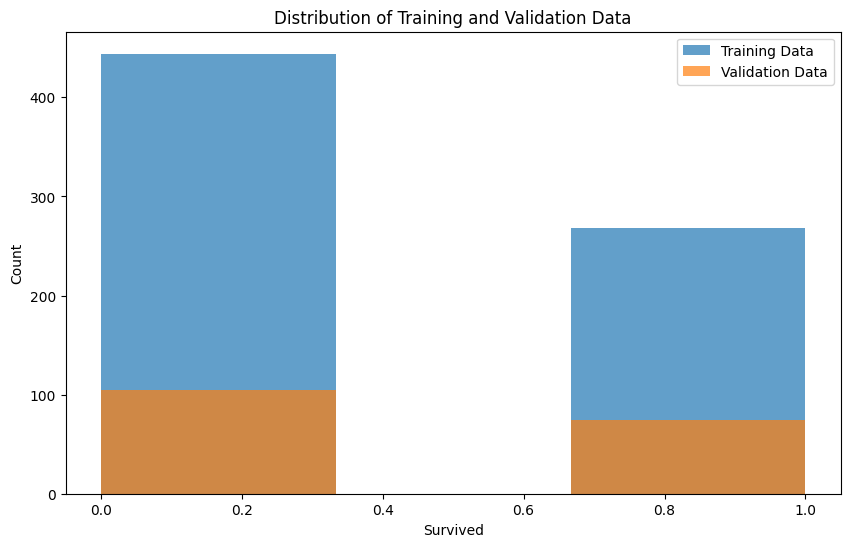

C:\Users\yosak\AppData\Local\Temp\ipykernel_16612\2135830364.py:86: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-np.array(z, dtype=np.float64)))


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.385
Model:                            OLS   Adj. R-squared:                  0.377
Method:                 Least Squares   F-statistic:                     48.76
Date:                Tue, 29 Oct 2024   Prob (F-statistic):           2.41e-68
Time:                        16:33:22   Log-Likelihood:                -321.44
No. Observations:                 712   AIC:                             662.9
Df Residuals:                     702   BIC:                             708.6
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.2595      0.087     14.409      0.0

c:\Users\yosak\anaconda3\envs\se411_Final_Project\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.3332 - mae: 0.4964 - val_loss: 0.2565 - val_mae: 0.4475
Epoch 2/1750
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2234 - mae: 0.4512 - val_loss: 0.2346 - val_mae: 0.4521
Epoch 3/1750
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2310 - mae: 0.4620 - val_loss: 0.2428 - val_mae: 0.4332
Epoch 4/1750
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2270 - mae: 0.4467 - val_loss: 0.2149 - val_mae: 0.4460
Epoch 5/1750
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2221 - mae: 0.4520 - val_loss: 0.2062 - val_mae: 0.4307
Epoch 6/1750
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2160 - mae: 0.4351 - val_loss: 0.2464 - val_mae: 0.3886
Epoch 7/1750
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2276 - mae: 0.4108 - val_loss: 0.2030 - val_mae: 0.4349
Epoch 8/1750
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2344 - mae: 0.4423 - val_loss: 0.2106 - val_mae: 0.4417
Epoch 9/1750
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2180 -

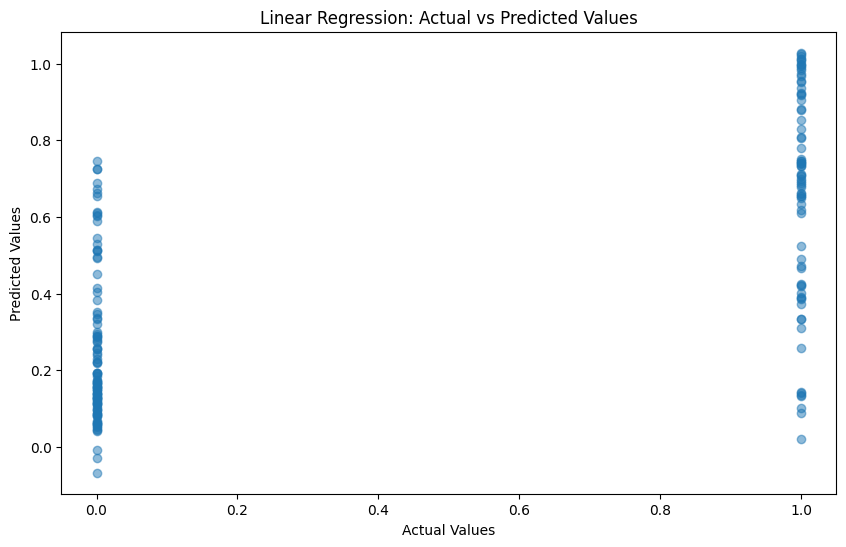


Logistic Regression Accuracy on validation set: 0.4301675977653631

Classification Report:
              precision    recall  f1-score   support

         0.0       0.60      0.09      0.15       105
         1.0       0.41      0.92      0.57        74

    accuracy                           0.43       179
   macro avg       0.51      0.50      0.36       179
weighted avg       0.52      0.43      0.32       179


Confusion Matrix:
[[ 9 96]
 [ 6 68]]


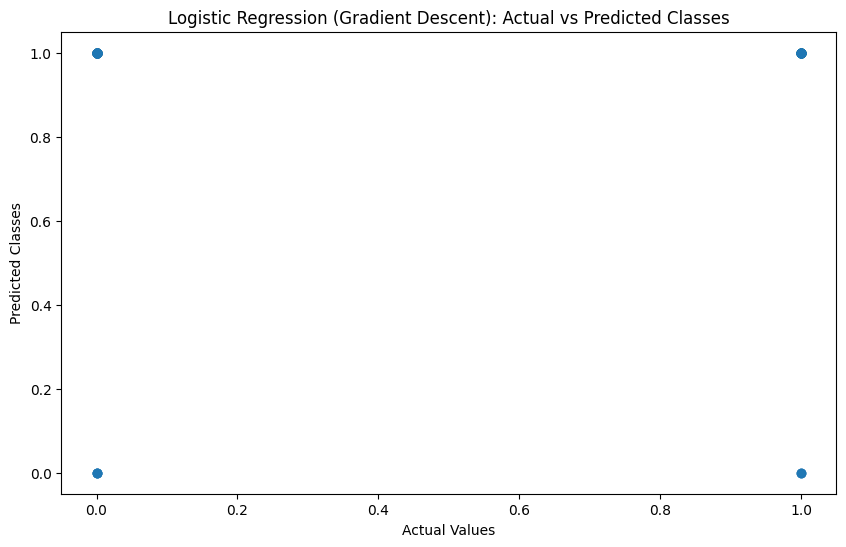


Neural Network Accuracy on validation set: 0.7430167597765364

Classification Report:
              precision    recall  f1-score   support

         0.0       0.80      0.74      0.77       105
         1.0       0.67      0.74      0.71        74

    accuracy                           0.74       179
   macro avg       0.74      0.74      0.74       179
weighted avg       0.75      0.74      0.74       179


Confusion Matrix:
[[78 27]
 [19 55]]


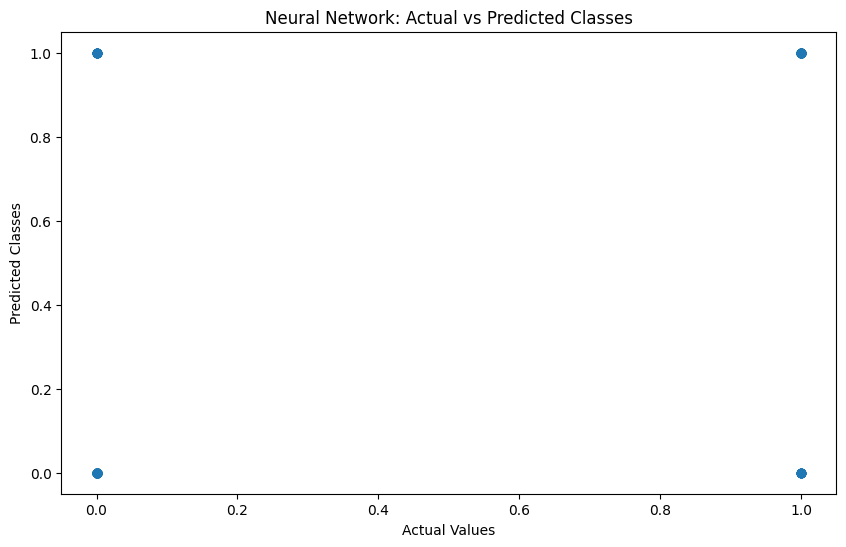

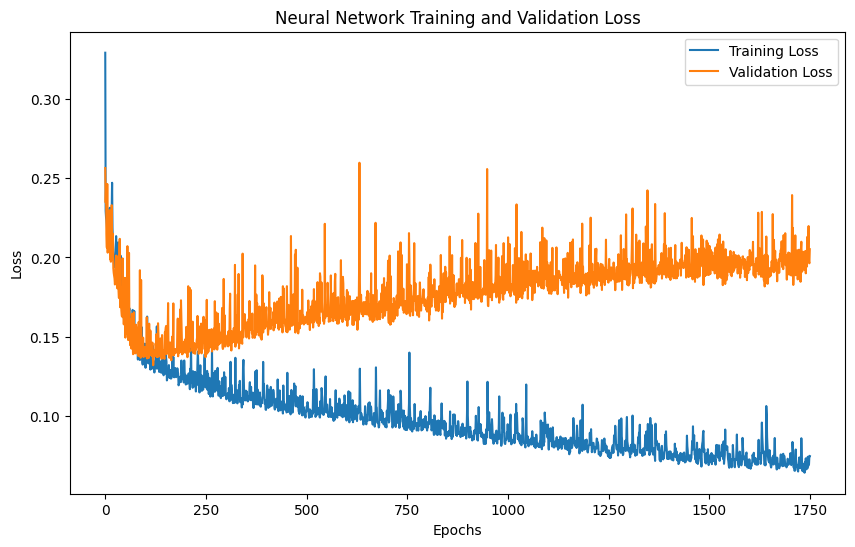

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import statsmodels.api as sm

# Section 1: Cleaning the Data
# Load the datasets
gender_submission = pd.read_csv('gender_submission.csv')
test = pd.read_csv('test.csv')
train = pd.read_csv('train.csv')

# Drop columns that are unnecessary or irrelevant for the analysis
columns_to_drop = ['Cabin', 'Ticket', 'Name']
train = train.drop(columns=columns_to_drop, errors='ignore')
test = test.drop(columns=columns_to_drop, errors='ignore')

# Handle missing values
train['Age'].fillna(train['Age'].median(), inplace=True)
test['Age'].fillna(test['Age'].median(), inplace=True)
train['Embarked'].fillna(train['Embarked'].mode()[0], inplace=True)
test['Embarked'].fillna(test['Embarked'].mode()[0], inplace=True)
test['Fare'].fillna(test['Fare'].median(), inplace=True)

# Convert categorical variables to numerical
train = pd.get_dummies(train, columns=['Sex', 'Embarked'], drop_first=True)
test = pd.get_dummies(test, columns=['Sex', 'Embarked'], drop_first=True)

# Ensure both train and test datasets have the same columns
missing_cols = set(train.columns) - set(test.columns)
for col in missing_cols:
    if col != 'Survived':
        test[col] = 0

test = test[train.columns.drop('Survived')]

# Save cleaned datasets
train.to_csv('cleaned_train.csv', index=False)
test.to_csv('cleaned_test.csv', index=False)

print("\nData cleaning complete. Cleaned data saved to '/mnt/data/'")

# Section 2: Train/Test the Data
# Split the training data into features and target
X = train.drop('Survived', axis=1).values.astype(np.float64)
y = train['Survived'].values.astype(np.float64)

# Split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Plot the training and validation data distribution
plt.figure(figsize=(10, 6))
plt.hist(y_train, bins=3, alpha=0.7, label='Training Data')
plt.hist(y_val, bins=3, alpha=0.7, label='Validation Data')
plt.xlabel('Survived')
plt.ylabel('Count')
plt.title('Distribution of Training and Validation Data')
plt.legend()
plt.show()

# Section 3: Modelling using Linear Regression, Gradient Descent, and Neural Network
# Linear Regression using Statsmodels
X_train_sm = sm.add_constant(X_train)
X_val_sm = sm.add_constant(X_val)
linear_model = sm.OLS(y_train, X_train_sm).fit()
print(linear_model.summary())

# Predict using linear regression model
y_pred_val_lr = linear_model.predict(X_val_sm)
y_pred_class_lr = np.array([1 if i > 0.5 else 0 for i in y_pred_val_lr])

# Train a logistic regression model using gradient descent
# Initialize parameters
n_features = X_train.shape[1]
weights = np.zeros(n_features, dtype=np.float64)
bias = 0.0
learning_rate = 0.01
n_iterations = 10000

# Sigmoid function
def sigmoid(z):
    return 1 / (1 + np.exp(-np.array(z, dtype=np.float64)))

# Training the model using gradient descent
for i in range(n_iterations):
    # Linear model
    linear_model_gd = np.dot(X_train, weights) + bias
    # Prediction
    y_predicted = sigmoid(linear_model_gd)
    
    # Compute gradients
    dw = (1 / len(y_train)) * np.dot(X_train.T, (y_predicted - y_train))
    db = (1 / len(y_train)) * np.sum(y_predicted - y_train)
    
    # Debugging prints
    if i % 1000 == 0:
        print(f"Iteration {i}: weights shape: {weights.shape}, dw shape: {dw.shape}, bias: {bias}, db: {db}")

    # Update parameters
    weights -= learning_rate * dw
    bias -= learning_rate * db

# Train a simple neural network model using TensorFlow
model = Sequential()
model.add(Dense(200, input_dim=n_features, activation='sigmoid'))
model.add(Dense(200, activation='sigmoid'))
model.add(Dense(200, activation='sigmoid'))
model.add(Dense(1, activation='linear'))

model.compile(optimizer='adam', loss='mse', metrics=['mae'])
history = model.fit(X_train.astype(np.float32), y_train.astype(np.float32), epochs=1750, batch_size=64, validation_data=(X_val.astype(np.float32), y_val.astype(np.float32)))

# Section 4: Prediction
# Make predictions on the validation set using gradient descent model
linear_model_val = np.dot(X_val, weights) + bias
y_pred_val_gd = sigmoid(linear_model_val)
y_pred_class_gd = np.array([1 if i > 0.5 else 0 for i in y_pred_val_gd])

# Make predictions on the validation set using neural network model
y_pred_nn_val = model.predict(X_val.astype(np.float32)).flatten()
y_pred_nn_class = np.array([1 if i > 0.5 else 0 for i in y_pred_nn_val])

# Make predictions on the test set using gradient descent model
linear_model_test = np.dot(test.values, weights) + bias
y_pred_test_gd = sigmoid(linear_model_test)
test_predictions_gd = np.array([1 if i > 0.5 else 0 for i in y_pred_test_gd])

# Make predictions on the test set using neural network model
y_pred_nn_test = model.predict(test.values.astype(np.float32)).flatten()
test_predictions_nn = np.array([1 if i > 0.5 else 0 for i in y_pred_nn_test])

# Save predictions
gender_submission['Survived'] = test_predictions_nn
gender_submission.to_csv('submission.csv', index=False)

print("\nTraining, testing, and prediction complete. Predictions saved to '/mnt/data/'")

# Section 5: Evaluation
# Ensure predictions are in the correct format
y_pred_class_lr = np.array(y_pred_class_lr).flatten()
y_pred_class_gd = np.array(y_pred_class_gd).flatten()
y_pred_nn_class = np.array(y_pred_nn_class).flatten()
y_val = y_val.flatten()

# Evaluate the linear regression model
y_pred_val_lr = y_pred_val_lr.flatten()
r2 = r2_score(y_val, y_pred_val_lr)
print("\nLinear Regression R-squared on validation set:", r2)

# Plot the linear regression results
plt.figure(figsize=(10, 6))
plt.scatter(y_val, y_pred_val_lr, alpha=0.5)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Linear Regression: Actual vs Predicted Values')
plt.show()

# Evaluate the gradient descent model
accuracy_gd = accuracy_score(y_val, y_pred_class_gd)
print("\nLogistic Regression Accuracy on validation set:", accuracy_gd)
print("\nClassification Report:")
print(classification_report(y_val, y_pred_class_gd))
print("\nConfusion Matrix:")
print(confusion_matrix(y_val, y_pred_class_gd))

# Plot the gradient descent results
plt.figure(figsize=(10, 6))
plt.scatter(y_val, y_pred_class_gd, alpha=0.5)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Classes')
plt.title('Logistic Regression (Gradient Descent): Actual vs Predicted Classes')
plt.show()

# Evaluate the neural network model
nn_accuracy = accuracy_score(y_val, y_pred_nn_class)
print("\nNeural Network Accuracy on validation set:", nn_accuracy)
print("\nClassification Report:")
print(classification_report(y_val, y_pred_nn_class))
print("\nConfusion Matrix:")
print(confusion_matrix(y_val, y_pred_nn_class))

# Plot the neural network results
plt.figure(figsize=(10, 6))
plt.scatter(y_val, y_pred_nn_class, alpha=0.5)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Classes')
plt.title('Neural Network: Actual vs Predicted Classes')
plt.show()

# Plot training and validation losses for neural network
if 'loss' in history.history and 'val_loss' in history.history:
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Neural Network Training and Validation Loss')
    plt.legend()
    plt.show()
else:
    print("The history object does not contain 'loss' or 'val_loss' keys.")
